# 8. Analiza języka (text mining)




Dane tekstowe wymagają specjalnego przygotowania zanim zaczniemy używać ich do modelowania i przeprowadzania analizy.
Tekst należy najpierw odpowiednio oczyścić a słowa muszą zostać zakodowane w postaci numerycznej (jako liczby całkowite lub zmiennoprzecinkowe), aby można je było wykorzystać jako dane wejściowe do algorytmu klasyfikacji lub klasteryzacji.

W poniższym notatniku znajduje się demonstracja następujących zagadnień związanych z analizą języka naturalnego:
* model worka słów (bag-of-words) - metoda reprezentacji dokumentów w postaci macierzy częstości występowania słów
* klasyfikacja dokumentów, na przykładzie analizy sentymentów w recenzjach filmowych
* modelowanie tematów - wykrywanie wspólnych tematów w tekstach i grupowanie dokumentów  tematycznie


## Model worka słów (bag-of-words)

Model worka słów jest uproszczoną reprezentacją tekstu stosowaną w przetwarzaniu języka naturalnego i wyszukiwaniu informacji. Pozwala utworzyć zestaw cech charakteryzujących analizowany fragment tekstu (dokument). 
Metoda ta zamienia tekst na wektor zawierający częstość występowania słów. Reprezentacja taka zawiera więc informację o tym czy dane słowo wystąpiło w dokumencie, jednak nie mamy tu informacji o gramatyce oraz kolejności słów. Słowa dokumentu są "wrzucone do worka", stąd nazwa metody.

<div>
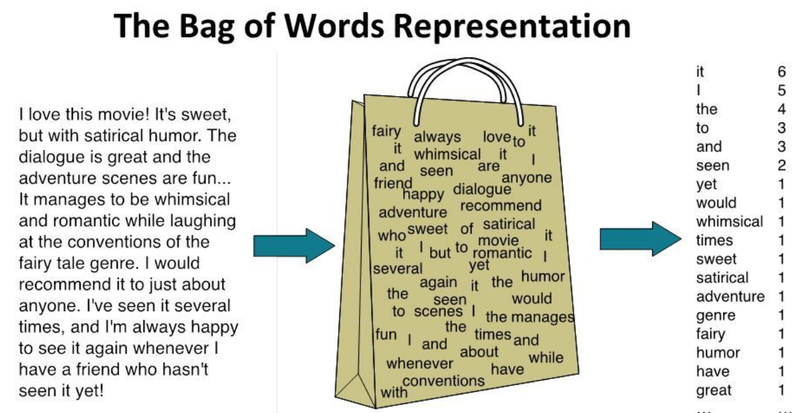
</div>

Spróbujmy prześledzić tworzenie reprezentacji wektorowej dokumentów na prostym przykładzie. 
Poniżej znajduje się zestaw 7 fragmentów teksu: pierwsze 4 dokumenty tematycznie nawiązują do artykułów na temat interfejsu człowiek-maszyna a ostatnie 3 dotyczą teorii grafów. 

In [ ]:
docs = ["Human machine interface for Lab ABC computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors A survey"]

Najpierw stwórzmy słownik zawierający wszystkie słowa w dokumencie. Przy okazji zliczmy ich częstotliwość występowania.
Słowa pisane wielką i małą literą traktujemy jednakowo. 


In [ ]:
# zamieniamy wszystki wielkie litery na małe 
docs = [d.lower() for d in docs]

# tworzymy słownik, który będzie zawierał pary (słowo, ilość wystąpień)
vocabulary = {}
for doc in docs:
    for word in doc.split():
        if word not in vocabulary:
            vocabulary[word] = 1
        else:
            vocabulary[word] += 1

# klucze słownika to lista unikatowych słów
words = vocabulary.keys()
            
print('Ilość unikatowych wyrazów:',  len(words))
print(" ".join(words))

Wyrazy ze słownika zakodujmy za pomocą kolejnych liczb całkowitych.

In [ ]:
# słownik przechowujący pary (słowo, index)
word2id = {}

for i, word in enumerate(words):
    word2id[word] = i
    print(word2id[word], word)
    

Utwórzmy teraz worek słów. Każdy dokument (wiersz macierzy) będzie wektorem o długości równej wielkości słownika. Wartości atrybutów to ilość wystąpień słowa w dokumencie. 

In [ ]:
import numpy as np

bag = np.zeros( (len(docs), len(words)), dtype=np.int32)

for i, doc in enumerate(docs):
    for word in doc.split():
        bag[i, word2id[word]] += 1
            
print(bag)

Poniżej znajduje się wizualizacja zawartości worka słów, która pozwoli lepiej zrozumieć zasadę wektoryzowania dokumentów.

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(bag, cmap='Reds')

plt.xticks(range(len(words)), words, rotation='vertical')
plt.colorbar()
plt.show()

Widać, że macierz ta jest rzadka, tzn. większość wartości jest zerowa. W praktycznych zastosowaniach, gdy mamy do czynienia z dużymi słownikami, zawierającymi tysiące unikatowych wyrazów, tylko znikoma ilość elementów będzie różna od zera. 
Każdy wiersz reprezentuje zdanie lub dokument scharakteryzowany częstością występowania wyrazów w tym dokumencie. Dokumenty podobne do siebie powinny posiadać podobne zestawy słów o zbliżonej częstości ich występowania. Dokumenty zawierające odmienne treści będą zawierały różne, charakterystyczne  dala danego zagadnienia słowa.

Tego typu macierz może posłużyć jako zbiór treningowy do wielu metod analizy danych, np. do klasyfikacji dokumentów lub wyszukiwania i grupowania podobnych dokumentów. 

Zobaczmy teraz jak wygląda częstość występowania wszystkich słów w analizowanym tekście.

In [ ]:
import pandas as pd
import seaborn as sb

wfd = pd.DataFrame( columns = ['word','n'])
wfd['word'] = vocabulary.keys()
wfd['n'] = vocabulary.values()
wdf_sorted = wfd.sort_values(by=['n'], ascending=False)

bar = sb.barplot(x="word", y="n", data=wdf_sorted)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90);

Najczęściej występuje słowo `of`. Niewiele mniej częsty okazał się wyraz `the`. Jeżeli wyraz występuje w wielu dokumentach to znaczy, że nie jest pomocny w rozróżnianiu tych dokumentów. Dlatego, powszechnie występujące wyrazy usuwa się z analizy. Dodatkowo słowa takie jak np. `the` lub `a` nie mają semantycznego znaczenia i również powinniśmy je usunąć.

Poniżej znajduje się lista słów z języka angielskiego, które zwyczajowo usuwa się przy tworzeniu worka słów.


In [ ]:
stop_words =['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself',
            'yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself',
            'they','them','their','theirs','themselves','what','which','who','whom','this','that',
            'these','those','am','is','are','was','were','be','been','being','have','has','had',
            'having','do','does','did','doing','a','an','the','and','but','if','or','because','as',
            'until','while','of','at','by','for','with','about','against','between','into','through',
            'during','before','after','above','below','to','from','up','down','in','out','on','off',
            'over','under','again','further','then','once','here','there','when','where','why','how',
            'all','any','both','each','few','more','most','other','some','such','no','nor','not',
            'only','own','same','so','than','too','very','s','t','can','will','just','don','should',
            'now','uses','use','using','used','one','also']

Utwórzmy jeszcze raz model worka słów pozbywając się tych wyrazów.

In [ ]:
words = []
for doc in docs:
    for word in doc.split():
        if word not in stop_words: 
            words.append(word)

words = set(words)

print('Ilość unikatowych słow:',  len(words))
            
word2id = dict(zip(words, range(len(words))))

bag = np.zeros( (len(docs), len(words)), dtype=np.int32)
for i, doc in enumerate(docs):
    for word in doc.split():
        if word not in stop_words:
            bag[i, word2id[word]] += 1

print(bag)

Dokumenty zamienione na wektory cech możemy użyć do analizy. 
Przykładowo, zobaczmy jak wygląda podobieństwo dokumentów . W tym celu możemy policzyć odległość pomiędzy wektorami reprezentującymi dokumenty.

In [ ]:
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

distance_matrix = pairwise_distances(bag, bag)

plt.matshow(distance_matrix)
plt.colorbar()
plt.show()

Każda wartość w macierzy reprezentuje odległość Euklidesową między parą dokumentów $d(\vec{x},\vec{y})$.
Metryka Euklidesowa nie jest najlepszym wyborem w tym wypadku. Widać, że dokument 0 jest prawie tak samo daleki od wszystkich pozostałych. Do porównywania podobieństwa dokumentów lepiej pasuje metryka kosinusowa równa $1-\cos(\vec{x},\vec{y})$. Dokumenty nie posiadające wspólnych słów będą reprezentowane w worku słów przez wektory ortogonalne, więc kosinus tego kąta wyniesie 0, zaś metryka kosinusowa przybierze maksymalną wartość 1. Dokumenty posiadające zbliżone zestawy słów będą miały kosinus kąta bliski 1, więc odległość kosinusowa tych dokumentów będzie bliska zeru. 

In [ ]:
distance_matrix = pairwise_distances(bag, bag, metric='cosine')
plt.matshow(distance_matrix)
plt.colorbar()
plt.show()

Wyraźnie widać, że pierwsze 4 dokumenty są podobne do siebie i różnią się do dokumentów 4,5,6. Również dokument przedostatni (5) i ostatni (6) zawierają podobne słowa. 
Kolor żółty oznacza odległość 1 dla par dokumentów, które nie posiadają wspólnych słów.

## Model worka słow w scikit-learn

Pakiet `scikit-learn` pozwala tworzyć worek słow za pomocą obiektu [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).
Argument `lowercase=True` automatycznie zamieni duże znaki na małe a `stop_words='english'` odsieje nieistotne słowa z języka angielskiego. `CountVectorizer` to model transformacji danych, którego dopasowanie do danych treningowych realizowane jest za pomocą metody `fit` lub `fit_transfrom`. 

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(lowercase=True, stop_words='english')
docs = np.array(docs)
bag = count.fit_transform(docs)

Wynikiem działania jest worek słow w postaci macierzy rzadkiej.

In [ ]:
print('Typ zmiennej: ', type(bag))
print(bag)

Zobaczmy jak wygląda to w postaci "gęstej" macierzy.

In [ ]:
print(bag.toarray())

Poniższa wizualizacja jeszcze lepiej prezentuje uzyskany worek słów.

In [ ]:
plt.matshow(bag.toarray(), cmap='Reds')

words = count.get_feature_names()

plt.xticks(range(len(words)), words, rotation='vertical')
plt.colorbar()
plt.show()

Pole `vocabulary_` zawiera słownik wyrazów wraz z kodującymi je indeksami. 

In [ ]:
print(count.vocabulary_)

Każdy nowy dokument możemy zamienić do tej reprezentacji za pomocą metody `transform`.


In [ ]:
text = ['Do trees understand human']

new_bag = count.transform(text)

print(new_bag.toarray())

Znajdźmy najbardziej podobny dokument ze zbioru treningowego do tekstu `"Do trees understand human"`

In [ ]:
min_dist = np.argmin(pairwise_distances(bag, new_bag, metric='cosine'))
print("Najbardziej podobny doument: ", docs[min_dist])


<br>

## Ocena istotności wyrazów za pomocą ważenia częstości wyrazów 

Często występujące słowa zwykle nie zawierają użytecznych lub dyskryminujących informacji. Wcześniej odfiltrowaliśmy słowa, które w języku angielskim występują często korzystając ze zdefiniowanej listy `stop_words`. Metoda __term frequency-inverse document frequency__ (tf-idf) pozwala zmniejszyć wagi często występujących słów w wektorach cech. 

Wartość tf-idf dla terminu $t$ w dokumencie $d$ zdefiniować można jako iloczyn częstości występowania terminu (wyrazu) w dokumencie $\text{tf} (t,d)$ i tzw. odwrotnej częstotliwości dokumentu $\text{idf}(t,d)$:

$$\text{tf-idf}(t,d)=\text{tf} (t,d)\times \text{idf}(t,d)$$


Częstość terminu $\text{tf}(t,d)$  to wartość, którą dotychczas używaliśmy do reprezentowania cech w modelu worka słów. Odwrotna częstotliwość dokumentu $\text{idf}(t,d)$  jest postaci:

$$\text{idf}(t,d) = \text{log}\frac{n_d}{1+\text{df}(d, t)},$$

gdzie $ n_d $ to całkowita liczba dokumentów, a  $\text{df}(d, t)$ to liczba dokumentów $d$, które zawierają termin $t$. Dodanie stałej 1 do mianownika jest opcjonalne i służy uniknięciu dzielenia przez zero w sytuacji gdy żaden dokument nie zawiera wyrazu $t$.
Czynnik $\text{idf}(t,d)$ zmniejsza więc wage wyrazów w worku słów, które pojawiają się często we wszystkich dokumentach (dla dużych $\text{df}(d, t)$).

Scikit-learn implementuje transformator `TfidfTransformer`, który pobiera nieprzetworzone częstotliwości z` CountVectorizer` jako dane wejściowe i przekształca je do postaci tf-idf.
Dodatkowo wszystkie wartości w wierszach (dla pojedynczego dokumentu) są normowane normą $L_2$ (argument `norm='l2'`).

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer( norm='l2')

x = tfidf.fit_transform(count.fit_transform(docs))


np.set_printoptions(precision=2)
print(x.toarray())   

In [ ]:
plt.matshow(x.toarray(), cmap='Reds')
words = count.get_feature_names()
plt.xticks(range(len(words)), words, rotation='vertical')
plt.colorbar()
plt.show()

Widać, że wyrazy, które częściej wstępują w tekście otrzymują mniejszą wagę. Największa wagę ma słowo `minors` (0.65) ponieważ występuje tylko w jednym dokumencie, przy czym ten dokument jest najkrótszy, ma tylko 3 wyrazy, więc normowanie wektora miało tu mniejszy wpływ niż np. na słowo `binary` (0.46), które również pojawia się tylko w jednym dokumencie ale w dłuższej sekwencji 5-sio wyrazowej.

Tak będzie wglądała macierz podobieństwa dokumentów w nowej reprezentacji.


In [ ]:
distance_matrix = pairwise_distances(x, x, metric='cosine')
plt.matshow(distance_matrix)
plt.colorbar()
plt.show()

## Analiza sentymentów 

Analiza sentymentu polega na określeniu, czy treść wpisu np. na forum internetowym ma charakter negatywny, pozytywny czy neutralny. Jest to więc zadanie klasyfikacji rozpoznające opinię autora tekstu. 
Spróbujmy przeprowadzić analizę sentymentów na rzeczywistych danych pochodzących z serwisu IMDB. Plik `movie_data.csv` zawiera 50 tysięcy recenzji filmów oznaczanych jako pozytywne lub negatywne. Przez recenzje pozytywne rozumiemy takie, które oceniały film na co najmniej 6 gwiazdek w 10-cio gwiazdkowej skali. Pozostałe recenzje, posiadające maksymalnie 5 gwiazdek, oznaczone są jako negatywne. 

Skompresowany plik z danymi o wielkości 26MB znajduje się pod adresem https://www.fizyka.umk.pl/~grochu/wdm/files/movie_data.csv.gz

Po rozpakowaniu plik zajmuje ok. 80MB.

In [ ]:
import pandas as pd

df = pd.read_csv('movie_data.csv.gz', compression='gzip', encoding='utf-8')

df.head(3)

In [ ]:
print('Ilość recenzji ', df.shape[0])
print('Ilość recenzji pozytywnych (1) i negatywnych (0)')
df.sentiment.value_counts()

Zmienna `review` zawiea recenzje - zobaczmy treść pierwszej recenzji.

In [ ]:
print(df.loc[0, 'review'])

Jest to recenzja fimu "Murder in Greenwich" z 2002 roku (https://www.imdb.com/title/tt0339422/), który otrzymał w IMDB 6.2 gwiazdki (pozytywny), dlatego zmienna `sentiment` ma wartość 1 dla tej recenzji. 

## Czyszczenie danych

Przed utworzeniem modelu worka słów lub reprezentacji tf-idf musimy przeprowadzić czyszczenie tekstu. W powyższym przykładzie widać, że recenzje obok znaków interpunkcyjnych posiadają również znaczniki HTML. Do analizy wybierzemy wyłącznie wyrazy, usuniemy wszystkie niepotrzebne znaki oraz elementy języka HTML. Stwórzmy w tym celu funkcję, która usuwa z tekstu niepotrzebne znaki. Bardzo przydatne w takich sytuacjach są wyrażenia regularne. Pythonowy pakiet `re` udostępnia szereg narzędzi działających na wyrażeniach regularnych, m. in. funkcję `sub` pozwalającą dokonywać zmiany w tekście.

In [ ]:

import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)             # usuwanie znaczników HTML
    text = re.sub('[\W]+', ' ', text.lower())      # pozbywamy się wszystkich znaków, które nie są literami
    return text

Zobaczmy jak sprawuje się funkcja `preprocessor`

In [ ]:
preprocessor("</a>To :) jest :( test :-)!")

Warto zauważyć, że nasza funkcja czyszcząca usuwa emotikony (np. `:-)`), które w analizie sentymentu mogą być bardzo przydatne, gdyż wyrażają emocje autora. Pomimo tego, nie zastosujemy ich w dalszej analizie.

In [ ]:
print(preprocessor(df.loc[0, 'review']))

Funkcja `apply` serii danych tabeli pandas pozwala zastosować funkcją transformacji na wszystkich elementach.

In [ ]:
df['review'] = df['review'].apply(preprocessor)

In [ ]:
print(df.loc[0, 'review'])

### Przygotowanie zbioru treningowego

Podzielmy zbiór danych na część treningową i testową. Część treningowa zostanie wykorzystana do zbudowania modelu a testowa posłuży do końcowej oceny jakości wykrywania sentymentów.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(df.review, df.sentiment, test_size = 0.5, random_state=42)

print('Trening: %d dokumentów' % len(X_train) )
print('Test   : %d dokumentów' % len(X_test) )


Dokumenty zamienimy do postaci wektorów cech metodą z ważonymi częstościami wyrazów `tf-idf`. Wykorzystajmy w tym celu transformator `TfidfVectorizer`, który w odróżnieniu od użytego wcześniej `TfidfTransformer` działa bezpośrednio na tekście. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

X_tfidf_train = tfidf.fit_transform(X_train)

print('Wielkość słownika:', len(tfidf.get_feature_names()))

Dane zawierają sporo dokumentów i bardzo dużo zmiennych. Użyjmy regresji logistycznej, gdyż jest ona metodą, która posiada małą złożoność obliczeniową, więc obliczenia nie będa trwały zbyt długo.

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=10, solver='lbfgs', random_state=0)
lr.fit(X_tfidf_train, y_train)



Sprawdźmy teraz poprawność wykrywania sentymentów na danych testowych. Oczywiście najpierw należy przetransformować recenzje testowe za pomocą takiej samej transformacji, która była użyta została do stworzenia zbioru treningowego.

In [ ]:
from  sklearn.metrics import accuracy_score

# transformacja zb. testowego
X_tfidf_test = tfidf.transform(X_test)

# predykcja na zbiorze testowym
y_pred = lr.predict(X_tfidf_test)

print('Poprawność klasyfikacji:', accuracy_score(y_test, y_pred))

Wynik bliski 90% poprawności jest całkiem niezły. Być może dobierając odpowiednio parametry klasyfikatora lub stosując inny klasyfikator udałoby się osiągnięć jeszcze lepszy wynik. 

Zobaczmy jak rozkładają się błędy w tablicy pomyłek

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, y_pred)
cc = pd.DataFrame(cm, columns=['negatywny', 'pozytywny'], index=['negatywny', 'pozytywny'])
cc.columns.name = 'predykcja'
cc.index.name = 'prawdziwa etykieta'
cc

## Modelowanie tematów

Model tematów (*topic model*) polega na odkrywaniu struktur semantycznych w tekście (grup tematycznych). Tutaj tematy są zdefiniowane przez grupy słów. Jeżeli zbiór dokumentów dotyczy określonego tematu, to  można oczekiwać, że pewne słowa pojawią się w dokumencie częściej lub rzadziej: „pies” i „kość” pojawią się częściej w dokumentach dotyczących psów a słowa „mąka” i „cukier” pojawią się w dokumentach na temat gotowania. Każdy dokument może być w różnym stopniu przypisany do wielu różnych tematów, wiąże się to z częstością pojawiania się w dokumencie słów przypisanych do różnych tematów. Modelowanie tematów jest więc metodą uczenia nienadzorowanego, która  grupuje zestawy wyrazów w grupy tematyczne oraz przypisuje dokumentom stopień przynależności do każdej z grup tematycznych.

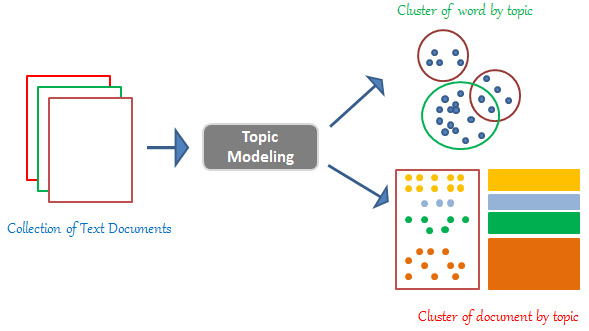

### Dekompozycja dokumentów tekstowych za pomocą Latent Dirichlet Allocation

Latent Dirichlet Allocation tworzy model statystyczny, w którym zakładamy, że każdy dokument jest mieszanką pewnej liczby tematów. Każdy temat z kolei scharakteryzowany jest częstością występowania pewnej grypy słów.  
Przykładowo, na poniższym wykresie temat $k$ jest określony przez częstość występowania pięciu słów, przy czym słowa `obama` i `speech` mają największą częstość występowania dla tego tematu. Dokument $d$ zawiera słowa, które wiążą go w różnym stopniu z tematami, przy czym temat `sports` i `news` mają tu największy wkład.

<div>
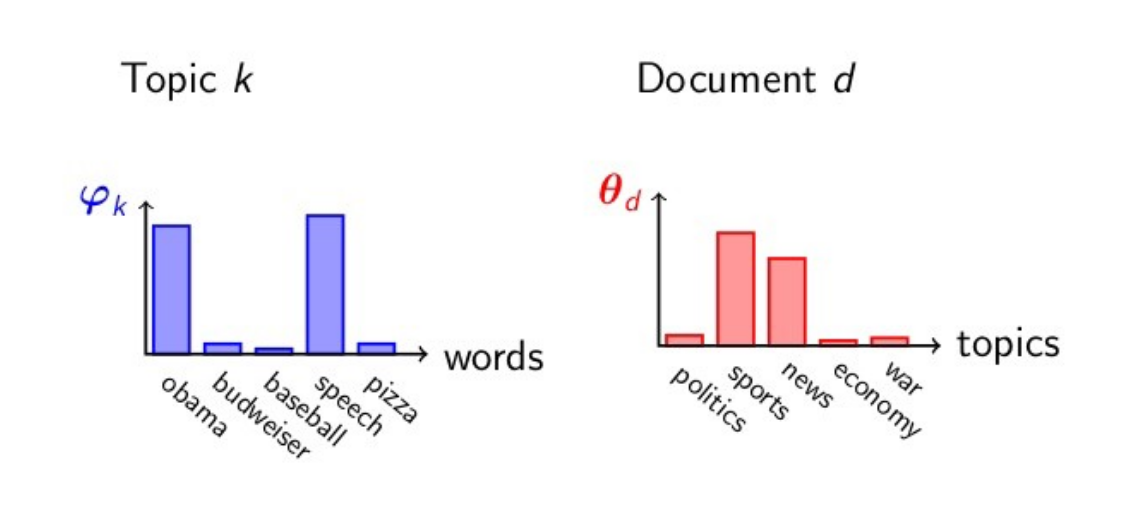
</div>

Model LDA powstaje w sposób iteracyjny i jego działanie ma charakter stochastyczny. Na początku działania algorytmu każdy wyraz jest w sposób losowy przydzielany do jednego z $k$ tematów. Należy zauważyć, że losowe przypisanie już zapewnia zarówno reprezentację tematyczną wszystkich dokumentów, jak i dystrybucję słów w tematach. Przypisanie początkowe jest losowe, więc dalekie od ideału, dlatego w kolejnych krokach LDA iteracyjne aktualizuje przypisanie słów do tematów dążąc do stanu równowagi, gdzie rozkłady prawdopodobieństw słów w tematach oraz tematów pośród dokumentów będą odpowiadać częstości występowania słów w analizowanych dokumentach. 
Proces dla każdego kolejnego słowa $w$ pochodzącego z dokumentu $d$ losuje przynależność tego słowa do tematu $t$ z prawdopodobieństwem danym przez

$$p(w |t) = p (t| d) * p (w | t)$$

gdzie $p ( t|  d)$ określa stopień powiązania tematu $t$ z dokumentem $d$. Im większe jest to prawdopodobieństwo tym większa szansa, że słowo $w$ będzie należało do tego tematu. Prawdopodobieństwo $p (w |  t)$ określa rozkład występowania słowa $w$ w tematach $t$ pośród wszystkich pozostałych dokumentów. Jeżeli to prawdopodobieństwo jest niskie dla pozostałych dokumentów to szansa, że $w$ zostanie przypasane do tego tematu maleje. Innymi słowy, w tym kroku zakładamy, że wszystkie przypisania tematów oprócz bieżącego słowa, o którym mowa, są poprawne, a następnie aktualizujemy przypisanie bieżącego słowa, korzystając z aktualnego modelu i rozkładów prawdopodobieństw tematów w dokumentach i rozkładów prawdopodobieństw słów w tematach.


### LDA w  scikit-learn

Przygotujmy najpierw zbiór treningowy. Ponieważ model LDA jest wymagający obliczeniowo ograniczmy wielkość zbioru treningowego do pierwszych 10 tysięcy recenzji. Dodatkowo, tworząc model worka słów można ograniczyć docelową wielkość słownika (ilość cech). Argument `max_features=5000` spowoduje, że dokumenty będą reprezentowane przez  5000 najczęściej występujących słów. Dodatkowo, argument `max_df=0.1` powoduje, że wyrazy, które występują w więcej niż 10% dokumentów będą ignorowane. 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english', max_features=5000, max_df=.1)
X = count.fit_transform(X_train[:10000])

Model LDA wykrywania tematów realizowany jest za pomocą klasy `LatentDirichletAllocation`. Głównym parametrem metody jest ilość szukanych tematów `n_components`. 
Zbudujmy model szukający 10 tematów.

Uwaga: wykonanie poniższej komórki  uruchamia proces szukania, który może zając kilka minut. W celu przyśpieszenia działania algorytmu można zmniejszyć liczbę dokumentów lub zmniejszyć ilość wyrazów w modelu worka słów, jednak spowoduje to pogorszenie jakości uzyskanego modelu oraz różnice w wynikach w stosunku do tego co opisane jest poniżej (powstaną inne grupy tematyczne).

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, random_state=42, verbose=1)

X_topics = lda.fit_transform(X)


Wynikiem transformacji LDA jest macierz `X_topics`, która zawiera tyle kolumn ile zdefiniowaliśmy tematów (`n_components=10`). 
Wartości w wierszu $i$-tym definiują prawdopodobieństwo tego, że $i$-ty dokument pochodzi z danego tematu. 
Zobaczmy jak wygląda wektor wartości `X_topic` dla pierwszej recenzji.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = np.arange(10) 
plt.bar(labels, X_topics[0, :])
plt.xticks(labels)
plt.xlabel('Tematy')
plt.title('Recenzja nr=0')
plt.show()

Recenzja ta stanowi mieszankę 3 tematów, przy czym najbardziej prawdopodobny jest temat 5.

Jak zdefiniowane są tematy? Zobaczmy jak wygląda przypisanie słów do poszczególnych tematów.
Informacja ta zawarta jest w zmiennej `components_` obiektu LDA. Jest to macierz o liczbie wierszy odpowiadającej liczbie tematów oraz liczbie kolumn równej ilości wyrazów z worka słów. Wartości określają wagę każdego wyrazu w generowaniu tematu. 

Zobaczmy jakie są najistotniejsze wyrazy dla tematu 5. 

In [ ]:
topic_words = lda.components_[5, :]

import pandas as pd
import seaborn as sb

wfd = pd.DataFrame( columns = ['word','weight'])
wfd['word'] = count.get_feature_names()
wfd['weight'] = lda.components_[5, :]
wdf_sorted = wfd.sort_values(by=['weight'], ascending=False)
wdf_sorted.head()

best_words = wdf_sorted.iloc[:20]


bar = sb.barplot(x="word", y="weight", data=best_words)
bar.set_xticklabels(bar.get_xticklabels(), rotation=90);

Zobaczmy jak zdefiniowane są wszystkie tematy. Wypiszmy 10 najważniejszych słów w każdej kategorii.

In [ ]:
n_top_words = 10

feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Temat %d:" % (topic_idx), end=' ')
    sorted_ids = topic.argsort()[::-1]
    print(" ".join([feature_names[i] for i in sorted_ids[:10]]))


Na podstawie przeczytania 10 najważniejszych słów dla każdego tematu możemy zgadywać jakie tematy odkrył LDA. Bardzo często taki temat będzie jednoznacznie związany z gatunkiem filmu. 

0. Seriale telewizyjne 
1. (Prawdopodobnie) filmy dokumentalne
2. Komedie
3. Ogólnie złe filmy (tak naprawdę nie jest to kategoria tematyczna)
4. Filmy wojenne  
5. Filmy akcji 
6. Filmy muzyczne
7. Science fiction
8. Filmy o tematyce rodzinnej
9. Filmy historyczne/wojenne, adaptacje książek


Aby potwierdzić, że kategorie mają sens na podstawie recenzji, wypiszmy 3 filmów z kategorii science fiction (kategoria 7):

In [ ]:
horror = X_topics[:, 7].argsort()[::-1]

for iter_idx, movie_idx in enumerate(horror[:3]):
    print('\nRecenzja #%d:' % (iter_idx + 1))
    print(X_train.values[movie_idx][:300], '...')

Korzystając z powyższego przykładu kodu, wydrukowaliśmy pierwsze 300 znaków z 3 recenzji o największym przyporządkowaniu do kategorii 7. Pierwsza pozycja nie wydaje się filmem science-fiction ale pozostałe dwie jak najbardziej pasują to tej kategorii. Lepszą jakość grupowania można uzyskać budując model dla większej liczby dokumentów (tu wybraliśmy 10 tysięcy ze względu na długi czas obliczeń).

## Zadania - Wykrywanie spamu


Zbuduj klasyfikator służący do wykrywania spamu na podstawie danych zawartych w pliku `spam_train.csv`.
Plik dostępny jest pod adresem: https://www.fizyka.umk.pl/~grochu/wdm/files/spam_train.csv

Zbiór treningowy zawiera 4000 wiadomości w języku angielskim oznaczonych jako `ham` (dokumenty dozwolone) lub `spam`. W celu zbudowania modelu wykrywającego spam wykonaj następujące czynności:
1. Wczytaj zbiór danych. Zmienna `Class` zawiera etykiety `ham` oraz `spam`. Zakoduj klasy w postaci liczb całkowitych: 0 (`ham`), 1 (`spam`).
2. Dokonaj wektoryzacji dokumentów do postaci worka słów lub tf-idf. Nie zapomnij o wcześniejszym oczyszczeniu tekstu z niepotrzebnych elementów (np. znaki interpunkcyjne).
3. Dla tak przygotowanego zbioru treningowego zbuduj model klasyfikacji wykrywający spam. Użyj w tym celu dowolnej metody z poprzednich zajęć (np. kNN, SVM, drzewo decyzyjne, regresja logistyczna). 
  - (Dla chętnych) Za pomocą przeszukiwani siatką (GridSearchCV) znajdź model klasyfikacji i dobierz jego parametry tak aby dawał jak najwyższą poprawność wykrywania spamu 
4. Przetestuj skuteczność zbudowanego modelu na danych testowych `spam_test.csv`. Plik znajduje się pod adresem https://www.fizyka.umk.pl/~grochu/wdm/files/spam_test.csv Wypisz uzyskaną poprawność i wyświetl tabelę pomyłek.




